# Introduction
In the following you will see how to read the provided files for the mini-project 3.
First you will see how to read each of the provided files. Then, you will see a more elegant way of using this data for training neural networks.

In [1]:
from google.colab.output import eval_js
eval_js('google.colab.output.setIframeHeight("10")')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive' )

%cd '/content/gdrive/MyDrive/Colab Notebooks/Mini Project 3 ECSE 551 Team 20'

import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1RXjBzfMRON_UZYkUp9X2psOg0iYCNREW/Mini Project 3 ECSE 551 Team 20


In [3]:
# Constants

TRAIN_LABELS_FILE = "./TrainLabels.csv"
TRAIN_DATA_FILE = './Train.pkl'
TEST_DATA_FILE = './Test.pkl'

BATCH_SIZE = 2**6
N_EPOCHS = 10
LEARNING_RATE = 0.001
RANDOM_SEED = 42
N_CLASSES = 9
IMG_SIZE_X = 128
IMG_SIZE_Y = 64



In [4]:
#-------------------------------DATA INSPECTION--------------------------------------------
def inspect_data():
  train = pd.read_csv(TRAIN_LABELS_FILE)

  fig = plt.figure()
  train['class'].value_counts().plot.bar()
  plt.ylabel("Observation count")
  plt.show()

  print((train['class'].value_counts()))
  print("Each class has the same number of observation ±1 data")

  # Read a pickle file and dispaly its samples
  # Note that image data are stored as unit8 so each element is an integer value between 0 and 255
  data = pickle.load( open( TRAIN_DATA_FILE, 'rb' ), encoding='bytes')
  targets = np.genfromtxt(TRAIN_LABELS_FILE, delimiter=',', skip_header=1)[:,1:]
  plt.imshow(data[1234,:,:],cmap='gray', vmin=0, vmax=256)
  print(data.shape, targets.shape)

#------------------------------DATASET CLASS--------------------------------------------------
class MyDataset(Dataset):
  # img_file: the pickle file containing the images
# label_file: the .csv file containing the labels
# transform: We use it for normalizing images (see above)
# idx: This is a binary vector that is useful for creating training and validation set.
# It return only samples where idx is True
  def __init__(self, img_file, targets, transform=None, idx = None):
      self.data = pickle.load(open( img_file, 'rb' ), encoding='bytes')
      self.targets = targets
      # self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1)[:,1:]
      if idx is not None:
        self.targets = self.targets[idx]
        self.data = self.data[idx]
      if transform is not None:
        self.transform = transform

  def __len__(self):
      return len(self.targets)

  def __getitem__(self, index):
      img, target = self.data[index], int(self.targets[index])
      img = Image.fromarray(img.astype('uint8'), mode='L')

      if self.transform is not None:
          img = self.transform(img)

      return img, target

#-----------------------------------------TRANSFORMS--------------------------------------------
# Transforms are common image transformations. They can be chained together using Compose.
# Here we normalize images img=(img-0.5)/0.5
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

#-------------------------------------DATA EXTRACTION, PROCESSING AND DIVISION INTRO TRAINING/TEST SETS ------------------------------
def extract_data(train_labels_file, train_data_file, batch_size, train_ratio):
  
  #Create the train dataset
  targets = np.genfromtxt(train_labels_file, delimiter=',', skip_header=1)[:,1:]


  #rescale so that target goes from 0 to 9
  min_target = min(targets)
  targets = targets - min_target


  train_size = int(len(targets) * train_ratio)
  test_size = len(targets) - train_size



  # Split the data into the training set and the test set  
  SS = ShuffleSplit(n_splits=1, train_size=train_size, test_size=test_size, random_state=RANDOM_SEED)


  train_index, test_index = next(SS.split(targets)) 


  train_dataset = MyDataset(train_data_file, targets , idx=train_index, transform=img_transform)
  test_dataset = MyDataset(train_data_file, targets , idx=test_index, transform=img_transform)

  train_loader = DataLoader(train_dataset ,batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset ,batch_size=batch_size, shuffle=True)

  return train_loader, test_loader
# --------------------------------------Other NEural network --------Le Net5------------------
# "https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320"


# -------------------------------VGG--------------------------------------
# --------------------------------------Other NEural network --------Le VGG------------------
# "https://www.youtube.com/watch?v=ACmuBbuXn20&ab_channel=AladdinPersson
VGG11 = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,512,'M']
VGG16 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,'M', 512, 512, 512, 'M']
class VGG_Net(nn.Module):

  def __init__(self, in_channels= 1, num_classes= N_CLASSES):
    super(VGG_Net, self).__init__()        
    self.in_channels = in_channels  
    self.conv_layers = self.create_conv_layers(VGG11)
    self.to_linear = 4096
    
    self.fcs = nn.Sequential(
        nn.Linear(self.to_linear,4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096,4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096,num_classes)
    )      

  def forward(self,x):
    x= self.conv_layers(x)
    x = x.reshape(x.shape[0],-1)
 
    x = self.fcs(x)
    return x

  def create_conv_layers(self, architecture):
    layers = []
    in_channels = self.in_channels

    for x in architecture:
      if type(x) == int:
        out_channels = x
        layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                             kernel_size = (3,3), stride=(1,1), padding=(1,1)),
                             nn.BatchNorm2d(x),
                             nn.ReLU()]
        in_channels = x
      elif x =='M':
        layers += [nn.MaxPool2d(kernel_size=(2,2), stride = (2,2))]
    
    return nn.Sequential(*layers)

#-----------------------------------------NEURAL NETWORK -------------------------------------------------------
class Net(nn.Module):
    # This part defines the layers
    def __init__(self):
        super(Net, self).__init__()
        # At first there is only 1 channel (greyscale). The next channel size will be 10. 
        input_sz_h = IMG_SIZE_Y
        input_sz_v = IMG_SIZE_X

        fltr_sz_cv_1 = 3
        fltr_num_cv_1 = 10
        fltr_sz_cv_2 = 3
        fltr_num_cv_2 = 10
        final_sz_h = np.floor(((input_sz_h-fltr_sz_cv_1+1)/2-fltr_sz_cv_2+1)/2)
        final_sz_v = np.floor(((input_sz_v-fltr_sz_cv_1+1)/2-fltr_sz_cv_2+1)/2)
        self.img_sz = int(fltr_num_cv_2 * final_sz_h * final_sz_v)

        self.conv1 = nn.Conv2d(1, fltr_num_cv_1, kernel_size=fltr_sz_cv_1)
        self.conv2 = nn.Conv2d(fltr_num_cv_1, fltr_num_cv_2, kernel_size=fltr_sz_cv_2)
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(self.img_sz, 40)
        self.fc2 = nn.Linear(40, N_CLASES)

    # And this part defines the way they are connected to each other
    # (In reality, it is our foreward pass)
    def forward(self, x):
        

        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, self.img_sz)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x,dim=0)

# ----------------------------------TRAINING -----------------------------------------
def train(network, optimizer,loss_function,train_loader, train_losses, train_accuracies_epochs):     
  no_of_correct_predictions = 0
  for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
    data = data.to(device)
    target = target.to(device)

    output = network(data)   
    predicted_targets_batch = output.data.max(1, keepdim=True)[1]  
    no_of_correct_predictions += predicted_targets_batch.eq(target.data.view_as(predicted_targets_batch)).sum()  
    

    target = target.to(device)
    data = data.to(device)
    optimizer.zero_grad()
    output = network(data)



    loss = loss_function(output, target)         
    loss.backward()      
    optimizer.step()      
    train_losses.append(loss.item())
  train_accuracy_epochs.append(float(100. * no_of_correct_predictions / len(train_loader.dataset)))

#-----------------------------------------TEST------------------------------------------


def test(network,loss_function, test_loader, test_losses, test_accuracy_epochs): 
  network.eval()
  test_loss = 0
  no_of_correct_predictions = 0

  with torch.no_grad():
    for X, y_truth in tqdm(test_loader): 
      X = X.to(device)
      y_truth = y_truth.to(device)

      y_hat = network(X)      
      test_loss += loss_function( y_hat, y_truth).item()      
      predicted_targets_batch = y_hat.data.max(1, keepdim=True)[1]  

      no_of_correct_predictions += predicted_targets_batch.eq(y_truth.data.view_as(predicted_targets_batch)).sum()  

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, no_of_correct_predictions, len(test_loader.dataset),
    100. * no_of_correct_predictions / len(test_loader.dataset)))
  test_accuracy_epochs.append(float(100. * no_of_correct_predictions / len(test_loader.dataset)))



# each number in train_losses vector correspond to a batch, while each on the test_losses correspond to an epoch
def plot_metrics(train_metrics,train_data_per_point, test_metrics, test_data_per_point,ylabel):
  train_data_seen = np.arange(len(train_metrics))* train_data_per_point
  test_data_seen = np.arange(len(test_metrics))*test_data_per_point
  fig = plt.figure()
  plt.scatter(test_data_seen, test_metrics, color='blue', label= 'Test')
  plt.scatter(train_data_seen, train_metrics, color='red', label = 'Train')
  plt.xlabel('Data seen')
  plt.ylabel(ylabel)
  plt.legend()

  plt.show()


In [5]:
train_loader, test_loader = extract_data(TRAIN_LABELS_FILE, TRAIN_DATA_FILE, BATCH_SIZE,0.8)
network = VGG_Net(in_channels=1,num_classes=N_CLASSES).to(device)

#loss_function = F.nll_loss
#optimizer = optim.SGD(network.parameters(), lr=LEARNING_RATE, momentum=0.5)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=LEARNING_RATE)

In [6]:
train_losses = []
test_losses = []
train_accuracy_epochs = []
test_accuracy_epochs = []

In [7]:
for epoch in range(2):
  train(network,optimizer,loss_function, train_loader, train_losses, train_accuracy_epochs) 
  print('\nTraining Epoch:{}   Loss: {}'.format(epoch, train_losses[-1])) 
  test(network,loss_function,test_loader, test_losses, test_accuracy_epochs)

750it [01:44,  7.17it/s]
  2%|▏         | 3/188 [00:00<00:07, 26.14it/s]

Training Epoch:0   Loss: 2.197819232940674


100%|██████████| 188/188 [00:06<00:00, 27.08it/s]
1it [00:00,  7.41it/s]


Test set: Avg. loss: 0.0344, Accuracy: 1391/12000 (12%)



750it [01:41,  7.41it/s]
  2%|▏         | 3/188 [00:00<00:07, 26.32it/s]

Training Epoch:1   Loss: 2.1981821060180664


100%|██████████| 188/188 [00:06<00:00, 27.33it/s]


Test set: Avg. loss: 0.0344, Accuracy: 1303/12000 (11%)



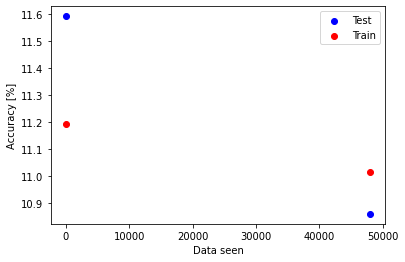

In [8]:
plot_metrics(train_accuracy_epochs, len(train_loader.dataset), test_accuracy_epochs, len(train_loader.dataset), 'Accuracy [%]')

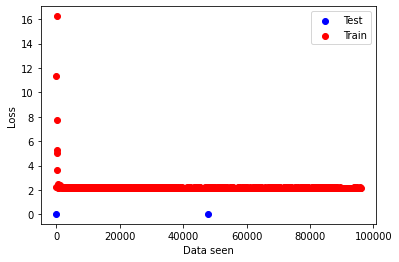

In [9]:
plot_metrics(train_losses,BATCH_SIZE, test_losses, len(train_loader.dataset), 'Loss')

In [10]:

class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.in_features_to_linear = 27000

        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.in_features_to_linear, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=N_CLASSES),
        )


    def forward(self, x):
      x = self.feature_extractor(x)
      x = torch.flatten(x, 1)  

      logits = self.classifier(x)


      probs = F.softmax(logits, dim=1)
      return probs
